#**MESSAGE PASSING INTERFACE (AULA 1)**

### **FUNDAMENTOS DE MPI**

**Message Passing Interface (MPI)** é um padrão para comunicação de dados em computação paralela. Existem várias modalidades de computação paralela, e dependendo do problema que se está tentando resolver, pode ser necessário passar informações entre os vários processadores ou nodos de um cluster, e o MPI oferece uma infraestrutura para essa tarefa.

No padrão MPI, uma aplicação é constituída por uma ou mais tarefas (as quais podem ser processos, ou threads, dependendo da implementação) que se comunicam, acionando-se funções para o envio e recebimento de mensagens entre os processos.

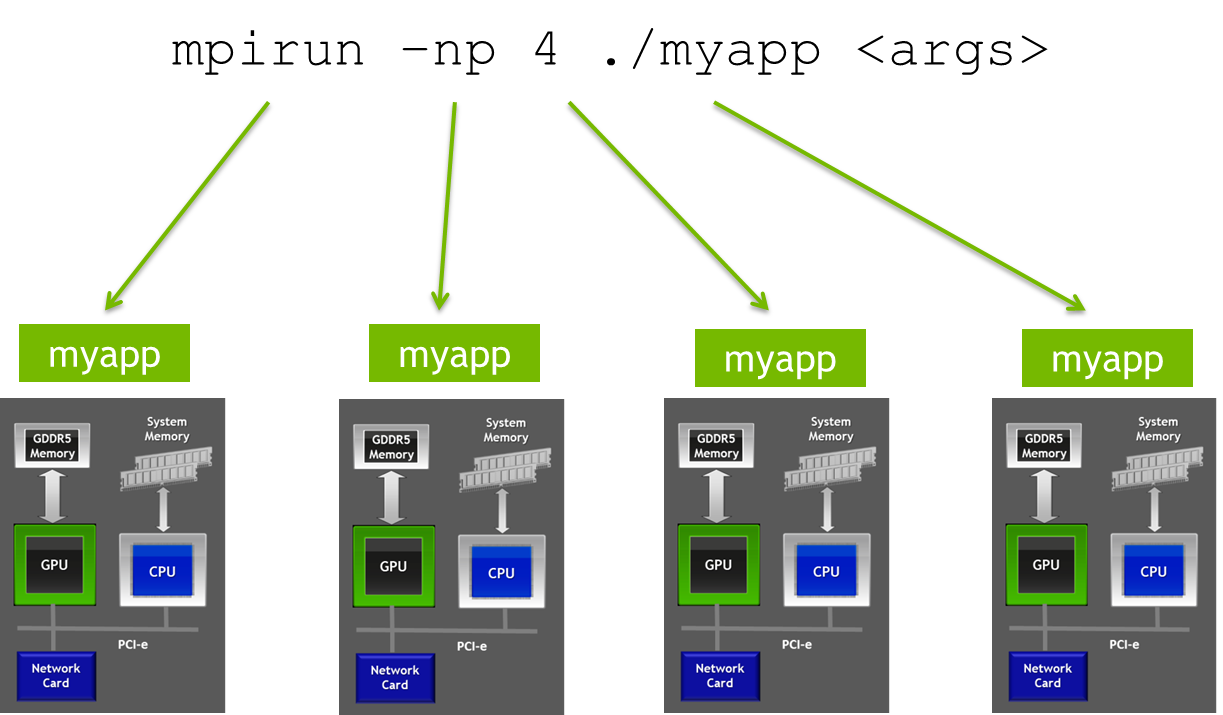

Inicialmente, na maioria das implementações, um conjunto fixo de processos é criado. Porém, esses processos podem executar diferentes programas. Por isso, o padrão MPI é algumas vezes referido como MPMD (multiple program multiple data). Elementos importantes em implementações paralelas são a comunicação de dados entre processos paralelos e o balanceamento da carga. Dado o fato do número de processos no MPI ser normalmente fixo, neste texto é enfocado o mecanismo usado para comunicação de dados entre processos. Os processos podem usar mecanismos de comunicação ponto a ponto (operações para enviar mensagens de um determinado processo a outro).

Um grupo de processos pode invocar operações coletivas (collective) de comunicação para executar operações globais. O MPI é capaz de suportar comunicação assíncrona e programação modular, através de mecanismos de comunicadores (communicator) que permitem ao usuário MPI definir módulos que encapsulem estruturas de comunicação interna.

### **CLUSTERS MPI**

**Cluster** é um termo em inglês que significa "aglomerado" ou "agregado" e pode ser aplicado em vários contextos. No caso de Supercomputação, o termo define uma arquitetura de sistema capaz combinar vários computadores para trabalharem em conjunto ou pode denominar o grupo em si de computadores combinados.

Cada estação é denominada “nodo” e, combinadas, formam o cluster. Em alguns casos, é possível ver referências como “supercomputadores” ou “computação em cluster” para o mesmo cenário, representando o hardware usado ou o software especialmente desenvolvido para conseguir combinar esses equipamentos.

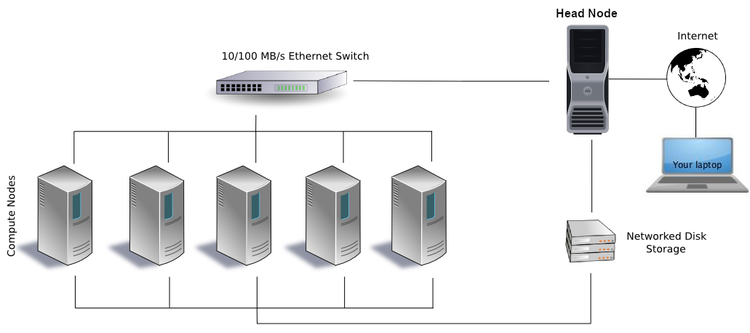

Os nodos são responsáveis pelas tarefas em execução. Seja o tráfego de requisições entrante ou requisições de recursos (mais memória para armazenamento de dados, por exemplo) são distribuídos para as máquinas que compõem o sistema. É literalmente um “todos por um”. Desde a mais simples até a mais complexa tarefa demandada é realizada com a força resultante da união dos recursos disponíveis. Neste modelo, a performance é priorizada e, caso alguma das estações falhe, ela é retirada do sistema e a tarefa é redistribuída entre as restantes.

Para construir os nossos clusters MPI, vamos usar o ambiente de simulação SIMGRID (http://www.simgrid.org). Ele permite especificar a arquitetura de um cluster (nodos e links) e simular a execução de aplicações distribuídas (MPI, por exemplo) sob este cluster.

Para definir a arquitetura de um cluster, usamos um arquivo XML. Por exemplo:

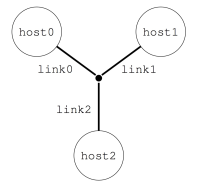

In [ ]:
%%writefile cluster1.xml

<?xml version='1.0'?>
<!DOCTYPE platform SYSTEM "https://simgrid.org/simgrid.dtd">
<platform version="4.1">
  <zone id="AS0" routing="Full">
    <host id="host0" speed="1Gf"/>
    <host id="host1" speed="2Gf"/>
    <host id="host2" speed="40Gf"/>
    <link id="link0" bandwidth="125MBps" latency="100us"/>
    <link id="link1" bandwidth="50MBps" latency="150us"/>
    <link id="link2" bandwidth="250MBps" latency="50us"/>
    <route src="host0" dst="host1"><link_ctn id="link0"/><link_ctn id="link1"/></route>
    <route src="host1" dst="host2"><link_ctn id="link1"/><link_ctn id="link2"/></route>
    <route src="host0" dst="host2"><link_ctn id="link0"/><link_ctn id="link2"/></route>
  </zone>
</platform>

Os elementos básicos (com \<host> e \<link>) são descritos primeiro e, em seguida, as rotas entre qualquer par de hosts são fornecidas explicitamente com \<route>. Qualquer host deve receber uma velocidade computacional em flops, enquanto os links devem receber uma latência e uma largura de banda. Você pode escrever 1Gf para 1.000.000.000 flops.

As rotas definidas com <route> são simétricas por padrão, o que significa que a lista de links percorridos de A a B é a mesma de B a A. Defina explicitamente rotas não simétricas, se preferir.

**EXERCÍCIO 1**

Especificar, através de um arquivo XML (cluster2.xml), um cluster contendo um nodo-mestre e oito nodos-escravos. As especificações dos links fica a seu critério.

In [ ]:
#COLOQUE SUA IMPLEMENTAÇÃO AQUI

Existem diversos modelos de clusters pre-definidos em SIMGRID. Para instalá-los no nosso ambiente, vamos executar os seguintes comandos:

In [ ]:
!apt install simgrid

In [ ]:
!git clone https://framagit.org/simgrid/simgrid-template-smpi.git

Os modelos de clusters estarão instalados no diretório **simgrid-template-smpi**. **Copie os modelos cluster1.xml e cluster2.xml para este diretório.**

### **APLICAÇÕES MPI**

Aplicações MPI fazem uso do header mpi.h, que disponibiliza uma série de funções para estrutura o ambiente de comunicação sob o cluster e realizar as comunicações entre os processos executando nos nodos.

Vamos considerar este primeiro exemplo, que faz uma comunicação em anel sob um cluster:

In [ ]:
%%writefile round.c

#include <mpi.h>
#include <stdio.h>
#include <stdlib.h>

#define N (1024 * 1024 * 1)

int main(int argc, char* argv[])
{
  int size, rank;
  struct timeval start, end;
  char hostname[256];
  int hostname_len;

  MPI_Init(&argc, &argv);

  MPI_Comm_rank(MPI_COMM_WORLD, &rank);
  MPI_Comm_size(MPI_COMM_WORLD, &size);
  MPI_Get_processor_name(hostname, &hostname_len);

  // Allocate a 1 MiB buffer
  char* buffer = malloc(sizeof(char) * N);

  // Communicate along the ring
  if (rank == 0) {
    gettimeofday(&start, NULL);
    printf("Rank %d (running on '%s'): sending the message rank %d\n", rank, hostname, 1);
    MPI_Send(buffer, N, MPI_BYTE, 1, 1, MPI_COMM_WORLD);
    MPI_Recv(buffer, N, MPI_BYTE, size - 1, 1, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
    printf("Rank %d (running on '%s'): received the message from rank %d\n", rank, hostname, size - 1);
    gettimeofday(&end, NULL);
    printf("%f\n", (end.tv_sec * 1000000.0 + end.tv_usec - start.tv_sec * 1000000.0 - start.tv_usec) / 1000000.0);

  } else {
    MPI_Recv(buffer, N, MPI_BYTE, rank - 1, 1, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
    printf("Rank %d (running on '%s'): receive the message and sending it to rank %d\n", rank, hostname,
           (rank + 1) % size);
    MPI_Send(buffer, N, MPI_BYTE, (rank + 1) % size, 1, MPI_COMM_WORLD);
  }

  MPI_Finalize();
  return 0;
}

**EXERCÍCIO 2**

Considere a seguinte documentação da MPI (https://www.mpi-forum.org/docs/mpi-3.0/mpi30-report.pdf). Com base nesta documentação, explique o funcionamento do código acima, colocando-os como comentários no código abaixo:

In [ ]:
%%writefile round.c

#include <mpi.h>
#include <stdio.h>
#include <stdlib.h>

#define N (1024 * 1024 * 1)

int main(int argc, char* argv[])
{
  int size, rank;
  struct timeval start, end;
  char hostname[256];
  int hostname_len;

  MPI_Init(&argc, &argv);

  MPI_Comm_rank(MPI_COMM_WORLD, &rank);
  MPI_Comm_size(MPI_COMM_WORLD, &size);
  MPI_Get_processor_name(hostname, &hostname_len);

  // Allocate a 1 MiB buffer
  char* buffer = malloc(sizeof(char) * N);

  // Communicate along the ring
  if (rank == 0) {
    gettimeofday(&start, NULL);
    printf("Rank %d (running on '%s'): sending the message rank %d\n", rank, hostname, 1);
    MPI_Send(buffer, N, MPI_BYTE, 1, 1, MPI_COMM_WORLD);
    MPI_Recv(buffer, N, MPI_BYTE, size - 1, 1, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
    printf("Rank %d (running on '%s'): received the message from rank %d\n", rank, hostname, size - 1);
    gettimeofday(&end, NULL);
    printf("%f\n", (end.tv_sec * 1000000.0 + end.tv_usec - start.tv_sec * 1000000.0 - start.tv_usec) / 1000000.0);

  } else {
    MPI_Recv(buffer, N, MPI_BYTE, rank - 1, 1, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
    printf("Rank %d (running on '%s'): receive the message and sending it to rank %d\n", rank, hostname,
           (rank + 1) % size);
    MPI_Send(buffer, N, MPI_BYTE, (rank + 1) % size, 1, MPI_COMM_WORLD);
  }

  MPI_Finalize();
  return 0;
}

Vamos, agora, compilar o código:

In [ ]:
!smpicc round.c -o round

Para executar o código compilado, fazemos:

In [ ]:
!smpirun -np 16 -platform simgrid-template-smpi/cluster_crossbar.xml -hostfile simgrid-template-smpi/cluster_hostfile ./round

Nesta execução, estamos usando 16 nodos (-np 16), **cluster_crossbar.xml** é a arquitetura do nosso cluster e **cluster_hostfile** são os nomes das máquinas do nosso cluster. O número final é o tempo de execução do processamento total.

**EXERCÍCIO 3**

Execute o código anterior nas arquiteturas cluster1.xml e cluster2.xml. Há alguma diferença no tempo de execução em função da arquitetura ?

In [ ]:
#FAÇA OS SEUS EXPERIMENTOS AQUI

**EXERCÍCIO 4**

Utilizando como base o código MPI anterior, construa um programa para obter uma aproximação de PI num cluster. Faça execuções em cluster com 8 e 16 processadores.

In [ ]:
#FAÇA SUA IMPLEMENTAÇÃO AQUI